# Lending Club Data Analysis

__Objective__ : The objective is to analyse the risk factors that attribute to a bad loan and generate sample data using SMOTE technique that can be used in future predictions of bad loans.

For the purpose of our analysis we have choosen the Lending Club data set. Lending Club is a peer to peer lending company based in the United States, in which investors provide funds for potential borrowers and investors earn a profit depending on the risk they take. Lending Club provides the "bridge" between investors and borrowers. Their operational statistics are public and available for download

Import the packages required before we move on to further analysis and data visualizations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from datetime import datetime as dt

import matplotlib.pyplot as plt

# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


from collections import Counter

# Other Libraries
import time

## Our Data

Examining the data we see that most of feature names are intuitive. We have above 74 columns. Let's work through our list of attributes slice-by-slice and figure out what we really need. This involves dropping some useless attributes and cleaning-up/modifying others. Let's work through the columns in batches to keep the cognitive burden low:

In [2]:
loan_df = pd.read_csv("F:/Python Projects/Lending club/loan.csv")
loan_df.info()

C:\Users\Karan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning:

Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835917 non-null object
emp_length                     842554 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [3]:
# .iloc[row slice, column slice] 
loan_df.iloc[:4,:7]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49


We won't need id or member_id as it has no real predictive power in our analysis so we can drop them from this table

In [4]:
loan_df.drop(['id','member_id'],1,inplace=True)

In [5]:
loan_df.iloc[:4,:14]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011


Rename the Columns loan_amnt, fundend_amnt, funded_amnt_inv, int_rate and annual_inc

In [6]:
loan_df = loan_df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds"
                                  ,"int_rate": "interest_rate", "annual_inc": "annual_income"})

We will be dropping installment and sub_grade columns as will not be considering these variable for our risk analysis

In [7]:
loan_df.drop(['installment','sub_grade'],1,inplace=True)

emp_title might be a free text field on the application form or a list of currated employment titles. Let's examine how many unique values exist:

In [8]:
print(loan_df.emp_title.value_counts().head())
print(loan_df.emp_title.value_counts().tail())
loan_df.emp_title.unique().shape

Teacher             13469
Manager             11240
Registered Nurse     5525
Owner                5376
RN                   5355
Name: emp_title, dtype: int64
Diabetes education nurse                1
Las Vegas Office Administrator          1
Campus/Education Coordinator            1
Head of Billing Dept/ office manager    1
Fac. Manager                            1
Name: emp_title, dtype: int64


(299272,)

299272 unique entries among of 887379 observations seems like a bit of a stretch. We will be droping these values since will not be categorising the employee_title for our analysis

In [9]:
loan_df.drop(['emp_title'],1,inplace=True)

We could leave 'emp_length' as categorical data, but it shouldn't be treated as such or as ordinal data since the intervals are easy to determine. We can convert it into numerical data with a simple filter:

In [10]:
loan_df.emp_length.value_counts()

10+ years    291569
2 years       78870
< 1 year      70605
3 years       70026
1 year        57095
5 years       55704
4 years       52529
7 years       44594
8 years       43955
6 years       42950
9 years       34657
Name: emp_length, dtype: int64

In [11]:
loan_df.replace('n/a', np.nan,inplace=True)
loan_df.emp_length.fillna(value=0,inplace=True)
loan_df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_df['emp_length'] = loan_df['emp_length'].astype(int)

verification_status is not required as we'll not be doing any analysis on annual salary source being verified

In [12]:
loan_df.drop(['verification_status'],1,inplace=True) 

In [13]:
loan_df.iloc[:4,10:16]

,loan_status,pymnt_plan,url,desc,purpose,title
0,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer
1,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike
2,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business
3,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel


loan status is mutable value that represents the current state of the loan. We might want to examine if all the independent variables and/or interst rate to determine the probability of the loan status.

In [14]:
loan_df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

We'll be dropping pymnt_plan as it has the same current state info that loan_status had above. It indicates that the loan is in jeopardy and that the borrower has been placed on a payment plan.

Examining the unique counts of purpose show that they are lending club selected options;howver, title and desc are arbitrary free-text from the applicant.

In [15]:
loan_df.drop(['pymnt_plan','url','desc'],1,inplace=True)

In [16]:
loan_df.purpose.value_counts() 

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

Convert Date to 'yyyy-dd-mm' format. It will be easier for us to do date wise analysis

In [17]:
loan_df['issue_d']=pd.to_datetime(loan_df['issue_d'])

In [18]:
loan_df.iloc[:4,21:]

,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


delinq_2yrs specified the distribution of delinquency across all applicants. The field is blank for applicants having no delinquency hence filling the NaN with 0

In [19]:
loan_df['delinq_2yrs'].fillna(0,inplace=True)

In [20]:
loan_df.drop(['last_pymnt_d','last_pymnt_amnt', 'next_pymnt_d','last_credit_pull_d'],1, inplace=True)

In [21]:
loan_df.iloc[:4,41:]

,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
loan_df.drop(['total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
              'collections_12_mths_ex_med','mths_since_last_major_derog','mths_since_last_major_derog','policy_code','dti_joint'
              ,'acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m'],1, inplace=True)

In [23]:
loan_df.application_type.value_counts() 

INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64

In [24]:
loan_df.drop(['annual_inc_joint' , 'verification_status_joint' ],1, inplace=True)

In [25]:
loan_df.drop(['zip_code'],1,inplace=True)

In [26]:
loan_df.drop(['earliest_cr_line','inq_last_6mths','mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec',
         'revol_bal','revol_util','total_acc','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
         'open_il_6m','open_il_12m','open_il_24m','max_bal_bc','all_util','total_rev_hi_lim' ,'inq_fi',
         'total_cu_tl','inq_last_12m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m',
            'open_rv_24m','total_rec_prncp'],1, inplace=True)

In [27]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 17 columns):
loan_amount         887379 non-null float64
funded_amount       887379 non-null float64
investor_funds      887379 non-null float64
term                887379 non-null object
interest_rate       887379 non-null float64
grade               887379 non-null object
emp_length          887379 non-null int32
home_ownership      887379 non-null object
annual_income       887375 non-null float64
issue_d             887379 non-null datetime64[ns]
loan_status         887379 non-null object
purpose             887379 non-null object
title               887227 non-null object
addr_state          887379 non-null object
dti                 887379 non-null float64
delinq_2yrs         887379 non-null float64
application_type    887379 non-null object
dtypes: datetime64[ns](1), float64(7), int32(1), object(8)
memory usage: 111.7+ MB


# Exploratory Analysis and Visualization:

We will start our analysis by exploring the distribution of loan amount.

To understand the distribution of loan amount we need to find out-

What amount was mostly issued to borrowers
Which year issued the most loans
Summary: From the graphs below, we can conclude that-

Most of the loans issued were in the range of 10,000 to 20,000 USD
The year of 2015 was the year were most loans were issued
The loans applied by potential borrowers, the amount issued to the borrowers and the amount funded by investors arealmost the same, i.e.,most likely that qualified borrowers are going to get the loan they had applied for

C:\Users\Karan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Total committed by Investors')

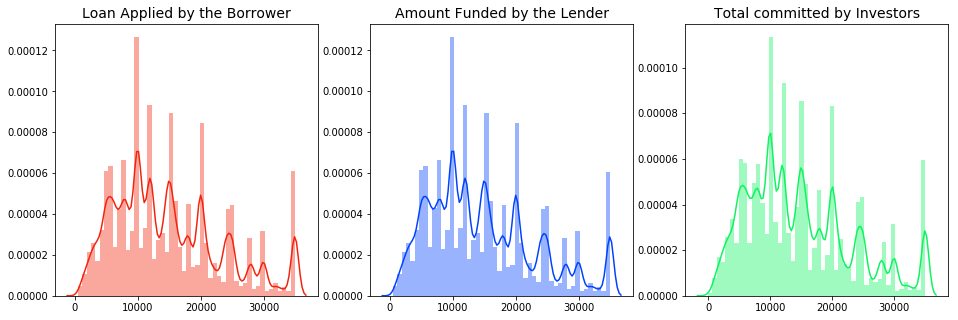

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amt = loan_df["loan_amount"].values
funded_amt = loan_df["funded_amount"].values
investor_funds = loan_df["investor_funds"].values

sns.distplot(loan_amt, ax=ax[0], color="#F4230D")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amt, ax=ax[1], color="#0042FF")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#0DF45F")
ax[2].set_title("Total committed by Investors", fontsize=14)

In [29]:
date_series = loan_df['issue_d']
loan_df['year'] = date_series.dt.year

Text(0, 0.5, 'Average loan amount issued')

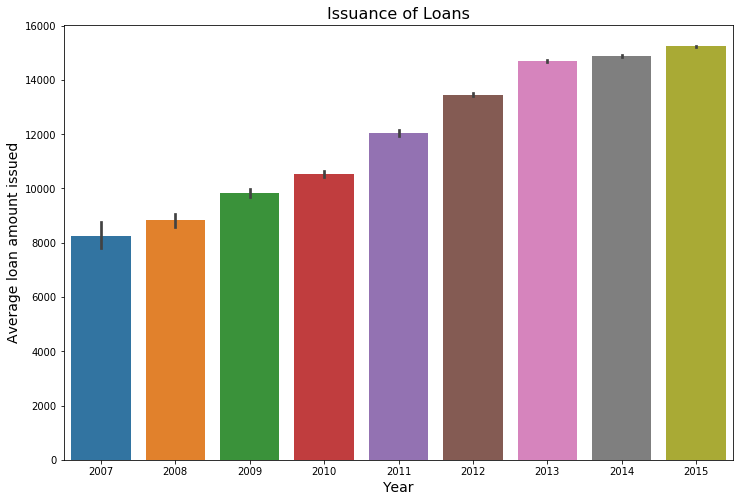

In [30]:
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amount', data=loan_df, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

### Good loans vs Bad loans

In this section we will categorizing good/bad loans and explore the distribution of good/bad loans accross different regions

Assumptions:

- The loans with status (Fully Paid, Current , Does not meet the credit policy. Status:Fully Paid) attribute to Good Loans
- The loans with status (Charged Off, Default , In Grace Period, Late ) attribute to Bad Loans
- The amount of bad loans could increment as the days pass by, since we still have a great amount of current loans
- Average annual income is an important key metric for finding possible opportunities of investments in a specific region

Summary:

- Currently good loans consists of 91.45% of the total loans and bad loans consists of 7.60%
- The NorthEast region seems to be the most attractive in term of funding loans to borrowers
- The SouthWest and West regions have experienced a slight increase in the "median income" in the past years
- Average interest rates have declined since 2012 but this might explain the increase in the volume of loans
- Employment Length tends to be greater in the regions of the SouthWest and West
- Clients located in the regions of NorthEast and MidWest have not experienced a drastic increase in debt-to-income(dti) as compared to the other regions.

In [31]:
# Calculate Good and Bad Loan Status Ratio
good_loan =  len(loan_df[(loan_df.loan_status == 'Fully Paid') |
                    (loan_df.loan_status == 'Current') | 
                    (loan_df.loan_status == 'Does not meet the credit policy. Status:Fully Paid')])
print ('Good Loan Ratio: %.2f%%'  % (good_loan/len(loan_df)*100))

Good Loan Ratio: 91.45%


In [32]:
# create an bad/good loan indicator feature
loan_df['good_loan'] = np.where((loan_df.loan_status == 'Fully Paid') |
                        (loan_df.loan_status == 'Current') | 
                        (loan_df.loan_status == 'Does not meet the credit policy. Status:Fully Paid'), 1, 0)

In [33]:
bad_loan =  len(loan_df[(loan_df.loan_status == 'Charged Off') |
                    (loan_df.loan_status == 'Default') | 
                    (loan_df.loan_status == 'Does not meet the credit policy. Status:Charged Off')|
                    (loan_df.loan_status == 'In Grace Period')|
                    (loan_df.loan_status == 'Late (16-30 days)')|
                    (loan_df.loan_status == 'Late (31-120 days)')])
print ('Bad Loan Ratio: %.2f%%'  % (bad_loan/len(loan_df)*100))

Bad Loan Ratio: 7.60%


In [34]:
loan_df['bad_loan'] = np.where((loan_df.loan_status == 'Charged Off') |
                        (loan_df.loan_status == 'Default') | 
                        (loan_df.loan_status == 'Does not meet the credit policy. Status:Charged Off')|
                    (loan_df.loan_status == 'In Grace Period')|
                    (loan_df.loan_status == 'Late (16-30 days)')|
                    (loan_df.loan_status == 'Late (31-120 days)'), 1, 0)

In [35]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


loan_df['loan_condition'] = np.nan

def loan_condition(loan_status):
    if loan_status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
loan_df['loan_condition'] = loan_df['loan_status'].apply(loan_condition)

[Text(0, 0.5, '(%)')]

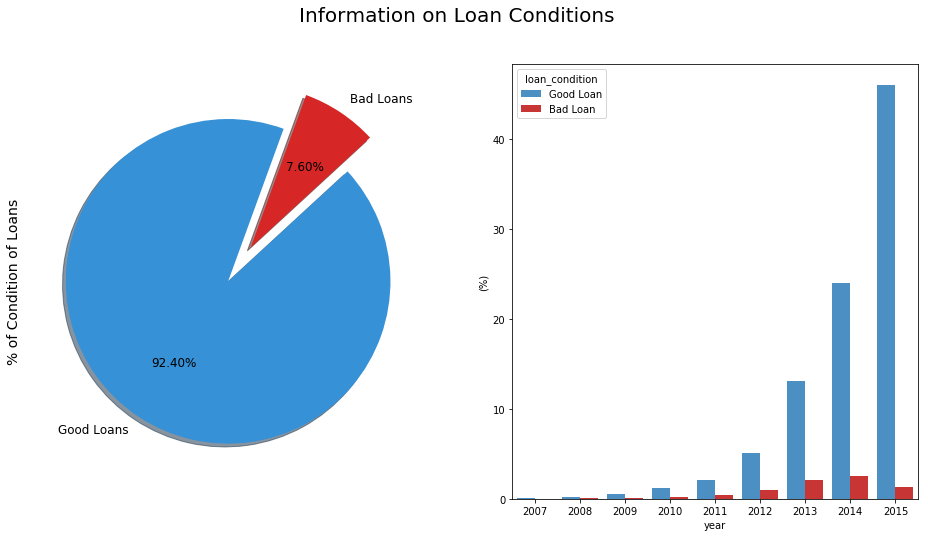

In [36]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

loan_df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=loan_df, palette=palette, estimator=lambda x: len(x) / len(loan_df) * 100)
ax[1].set(ylabel="(%)")

In [37]:
loan_df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

loan_df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


loan_df['region'] = loan_df['addr_state'].apply(finding_regions)

In [38]:
# This code will take the current date and transform it into a year-month format
loan_df['complete_date'] = loan_df['issue_d']

dates_region = loan_df.groupby(['complete_date', 'region'], as_index=False).sum()

dates_region['issue_d'] = [month.to_period('M') for 
                          month in dates_region['complete_date']]

dates_region = dates_region.groupby(['issue_d', 'region'], as_index=False).sum()
dates_region = dates_region.groupby(['issue_d', 'region'], as_index=False).sum()
dates_region['loan_amount'] = dates_region['loan_amount']/1000


df_dates = pd.DataFrame(data=dates_region[['issue_d','region','loan_amount']])

Text(0.5, 1.0, 'Loans issued by Region')

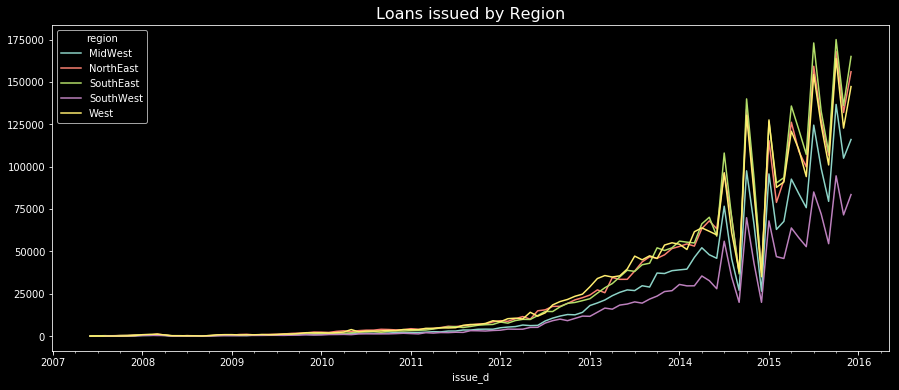

In [39]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

amount_issued = df_dates.groupby(['issue_d', 'region']).loan_amount.sum()
amount_issued.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

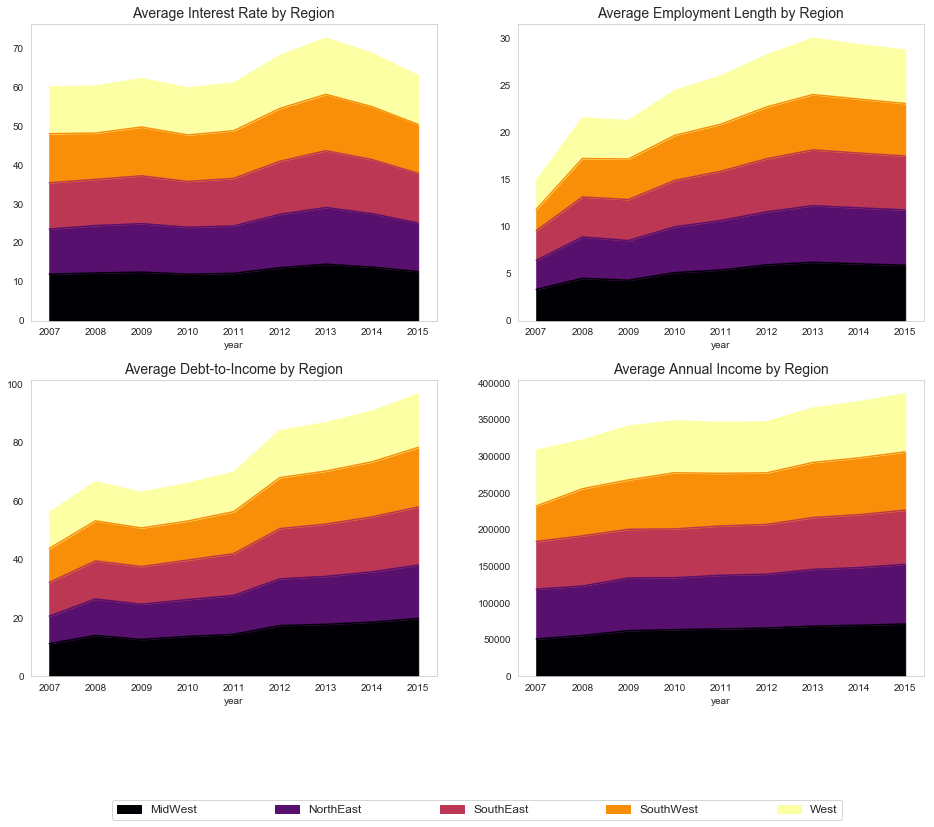

In [40]:
# Loan issued by Region and by Credit Score grade
# Change the colormap for tomorrow!

sns.set_style('whitegrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

interest_rate= loan_df.groupby(['year', 'region']).interest_rate.mean()
interest_rate.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


employment_length = loan_df.groupby(['year', 'region']).emp_length.mean()
employment_length.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)
# plt.xlabel('Year of Issuance', fontsize=14)

debit_to_income = loan_df.groupby(['year', 'region']).dti.mean()
debit_to_income.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

annual_income = loan_df.groupby(['year', 'region']).annual_income.mean()
annual_income.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

### Level of risk in a Particular Region

The level of risk accross all regions can be obtained by calculating the number of loans that were classified as bad loans for each region by its loan status

Summary:

- The regions of the West and SouthEast had a higher percentage in most of the bad loan statuses
- The NorthEast region had a higher percentage in Grace Period and Does not meet Credit Policy loan status. However, both of these are not considered as bad as default for instance
- Based on this small and brief summary we can conclude that the West and SouthEast regions have the most undesirable loan status, but just by a slightly higher percentage compared to the NorthEast region
- Again, this does not tell us what causes a loan to be a bad loan , but it gives us some idea about the level of risk within the regions across the United States.

In [41]:
badloans_df = loan_df.loc[loan_df["bad_loan"]==1]

In [42]:
# loan_status cross
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])

In [45]:
number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
# number_of_badloans
number_of_loanstatus

loan_status,Charged Off,Default,Does not meet the credit policy. Status:Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,,,
MidWest,7361,175,142,926,354,1820,32334
NorthEast,10671,263,190,1625,585,2799,48399
SouthEast,11094,297,184,1579,600,2925,50037
SouthWest,4774,166,79,708,273,1407,22221
West,11348,318,166,1415,545,2640,49296


In [46]:
charged_off = loan_status_cross['Charged Off'].values.tolist()
default = loan_status_cross['Default'].values.tolist()
not_meet_credit = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].values.tolist()
grace_period = loan_status_cross['In Grace Period'].values.tolist()
payment_short = loan_status_cross['Late (16-30 days)'] .values.tolist()
payment_long = loan_status_cross['Late (31-120 days)'].values.tolist()



charged = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= charged_off,
    name='Charged Off',
    marker=dict(
        color='rgb(192, 148, 246)'
    ),
    text = '%'
)

defaults = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y=default,
    name='Defaults',
    marker=dict(
        color='rgb(176, 26, 26)'
    ),
    text = '%'
)

policy_status = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= not_meet_credit,
    name='Does not meet Credit Policy',
    marker = dict(
        color='rgb(229, 121, 36)'
    ),
    text = '%'
)

grace = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= grace_period,
    name='Grace Period',
    marker = dict(
        color='rgb(147, 147, 147)'
    ),
    text = '%'
)

short_late_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= payment_short,
    name='Late Payment (16-30 days)', 
    marker = dict(
        color='rgb(246, 157, 135)'
    ),
    text = '%'
)

long_late_pay = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= payment_long,
    name='Late Payment (31-120 days)',
    marker = dict(
        color = 'rgb(238, 76, 73)'
        ),
    text = '%'
)

data = [charged, defaults, policy_status, grace, short_late_pays, long_late_pay]
layout = go.Layout(
    barmode='stack',
    title = '% of Bad Loan Status by Region',
    xaxis=dict(title='US Regions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

### Analysis by Income Category :

We will now create different income categories in order to detect loan defaulting patterns. We have categorised annual income into three categories- low, Medium and High

Assumptions:

- Low: Borrowers that have an annual income<=100,000 USD
- Medium: Borrowers that have an annual income>100,000 USD & annual income<= 200,000 USD
- High: Borrowers that have an annual income> 200,000 USD

Summary:

- Borrowers having high income took higher loan amounts than people from low and medium income categories
- Borrowers with High and Medium annual incomes had longer employment length than people with lower incomes
- Borrowers with a lower income had on average higher interest rates while people with a higher annual income had lower interest rates on their loans
- People with higher annual incomes are more likely to pay loans with a higher amount
- Loans borrowed by people having low income categories have higher chance of becoming a bad loan

In [47]:
# Let's create categories for annual_income since most of the bad loans are located below 100k

loan_df['income_category'] = np.nan
lst = [loan_df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

In [48]:
# Let's transform the column loan_condition into integrers.

lst = [loan_df]
loan_df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[loan_df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[loan_df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
loan_df['loan_condition_int'] = loan_df['loan_condition_int'].astype(int)

C:\Users\Karan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



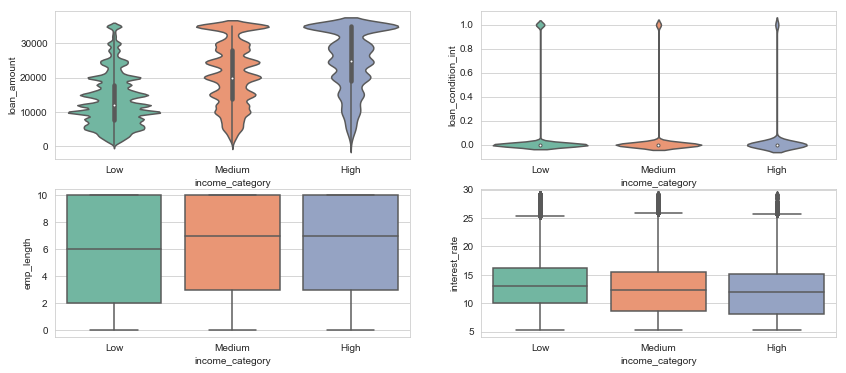

In [49]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amount", data=loan_df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=loan_df, palette="Set2", ax=ax2)
sns.boxplot(x="income_category", y="emp_length", data=loan_df, palette="Set2", ax=ax3)
sns.boxplot(x="income_category", y="interest_rate", data=loan_df, palette="Set2", ax=ax4)

### Assesing Risks

We have to analyze the level of risk in each state. The important metrices to consider are Credit scores, Debt-to-income and average length of employment.

Summary:

- IOWA has the highest level of default ratio, the amount of loans issued in that state is too low so we can really infer the risk level in that particular state
- California and Texas seem to have the lowest risk and the highest possible return for investors

In [50]:
group_condition = loan_df.groupby('addr_state')['loan_condition'].value_counts()/ loan_df.groupby('addr_state')['loan_condition'].count()
group_emp_length = loan_df.groupby(['region', 'addr_state'], as_index=False).emp_length.mean().sort_values(by="addr_state")

In [51]:
loan_condition_bystate = pd.crosstab(loan_df['addr_state'], loan_df['loan_condition'] )

cross_condition = pd.crosstab(loan_df["addr_state"], loan_df["loan_condition"])
# Percentage of condition of loan
percentage_loan_contributor = pd.crosstab(loan_df['addr_state'], loan_df['loan_condition']).apply(lambda x: x/x.sum() * 100)
condition_ratio = cross_condition["Bad Loan"]/cross_condition["Good Loan"]
by_dti = loan_df.groupby(['region', 'addr_state'], as_index=False).dti.mean()

In [52]:
# Take to a list
default_ratio = condition_ratio.values.tolist()
average_dti = by_dti['dti'].values.tolist()
average_emp_length = group_emp_length['emp_length'].values.tolist()
number_of_badloans = loan_condition_bystate['Bad Loan'].values.tolist()
percentage_ofall_badloans = percentage_loan_contributor['Bad Loan'].values.tolist()
states = loan_df['addr_state'].unique()
state_codes = sorted(states)

In [53]:
from collections import OrderedDict
risk_data = OrderedDict([('state_codes', state_codes),
                         ('default_ratio', default_ratio),
                         ('badloans_amount', number_of_badloans),
                         ('percentage_of_badloans', percentage_ofall_badloans),
                         ('average_dti', average_dti),
                         ('average_emp_length', average_emp_length)])
# Figure 2 Dataframe 
risk_df = pd.DataFrame(risk_data)
risk_df = risk_df.round(decimals=3)
risk_df.head()

,state_codes,default_ratio,badloans_amount,percentage_of_badloans,average_dti,average_emp_length
0,AK,0.074,151,0.224,13.656,6.072
1,AL,0.097,993,1.473,17.821,6.210
2,AR,0.083,507,0.752,19.681,5.968
3,AZ,0.084,1581,2.345,19.284,5.459
4,CA,0.088,10518,15.599,18.683,5.742


In [54]:
# Now it comes the part where we plot out plotly United States map
import plotly.plotly as py
import plotly.graph_objs as go


for col in risk_df.columns:
    risk_df[col] = risk_df[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

risk_df['text'] = risk_df['state_codes'] + '<br>' +\
'Number of Bad Loans: ' + risk_df['badloans_amount'] + '<br>' + \
'Percentage of all Bad Loans: ' + risk_df['percentage_of_badloans'] + '%' +  '<br>' + \
'Average Debt-to-Income Ratio: ' + risk_df['average_dti'] + '<br>'+\
'Average Length of Employment: ' + risk_df['average_emp_length'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df['default_ratio'], 
        locationmode = 'USA-states',
        text = risk_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]


layout = dict(
    title = 'Lending Clubs Default Rates <br> (Analyzing Risks)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

### Analysis based on Credit Scores

We will analyze the level of risk as a whole and how many loans were bad loans by the type of grade received in the credit score of the customer

Summary:

- The scores that has a lower grade received a larger amounts of loans which might contribute to a higher level of risk
- The lower the grade the higher the interest the customer had to pay back to investors
- Customers with a grade C were more likely to default on the loan

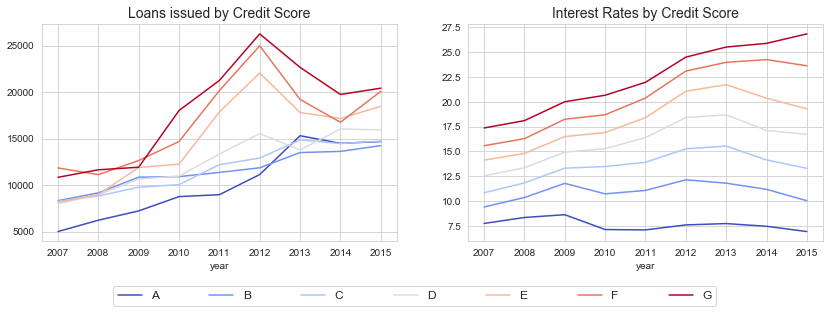

In [55]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = loan_df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = loan_df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

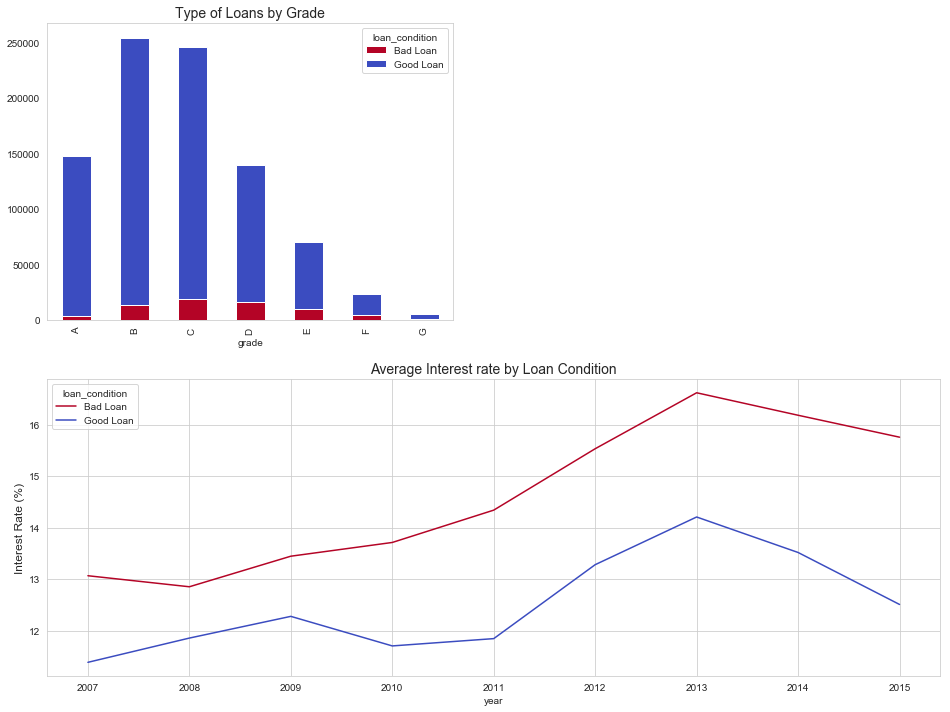

In [56]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = loan_df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


by_interest = loan_df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

### Analysis on Factors determining a Bad Loan

We will be analysing the main factors that attributes to a bad loan.

Assumptions:

- Low credit grades or a high debt to income could be possible contributors in determining whether a loan is at a high risk of being defaulted

Summary:

- The main factors that increase risk include: low annual income, high debt to income, high interest rates and low grade
- People who have mortgages that are applying for a higher loan amounts were considered as bad

In [57]:
# Just get me the numeric variables
numeric_variables = loan_df.select_dtypes(exclude=["object"])

In [58]:
# We will use df_correlations dataframe to analyze our correlations.


df_correlations = loan_df.corr()


trace = go.Heatmap(z=df_correlations.values,
                   x=df_correlations.columns,
                   y=df_correlations.columns,
                  colorscale=[[0.0, 'rgb(165,0,38)'], 
                              [0.1111111111111111, 'rgb(215,48,39)'], 
                              [0.2222222222222222, 'rgb(244,109,67)'], 
                              [0.3333333333333333, 'rgb(253,174,97)'], 
                              [0.4444444444444444, 'rgb(254,224,144)'], 
                              [0.5555555555555556, 'rgb(224,243,248)'], 
                              [0.6666666666666666, 'rgb(171,217,233)'], 
                              [0.7777777777777778, 'rgb(116,173,209)'], 
                              [0.8888888888888888, 'rgb(69,117,180)'], 
                              [1.0, 'rgb(49,54,149)']],
            colorbar = dict(
            title = 'Level of Correlation',
            titleside = 'top',
            tickmode = 'array',
            tickvals = [-0.52,0.2,0.95],
            ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
            ticks = 'outside'
        )
                  )


layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

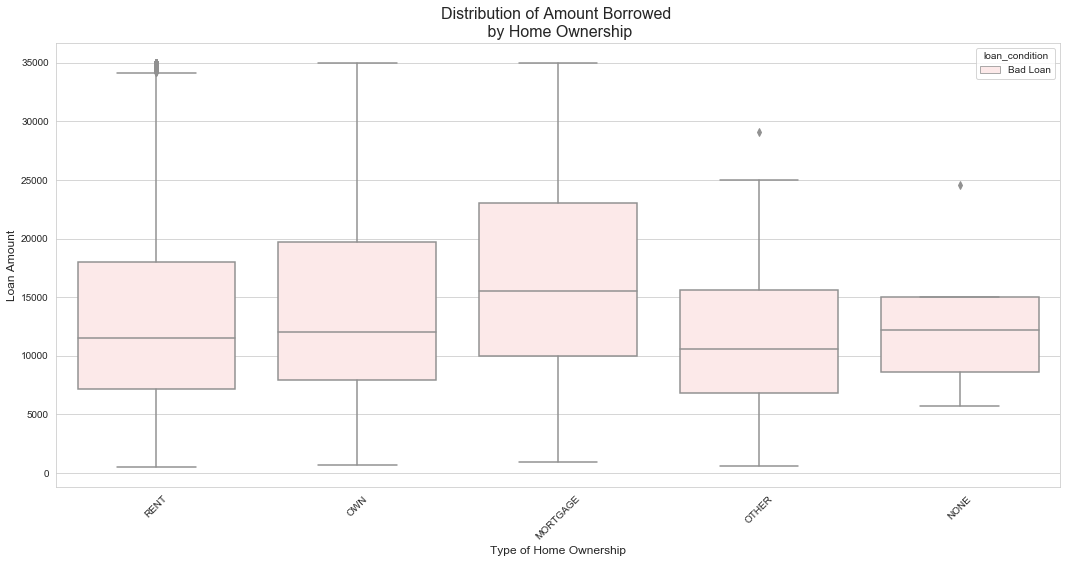

In [59]:
plt.figure(figsize=(18,18))

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='loan_amount', hue='loan_condition',
               data=badloans_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)
plt.show()

### Defaulted Loans and Levels of Risk

As we seen above there are different types of bad loans, the one important category among these are the "Defaulted". Hence, in this section we will use an in dept-analysis on these types of loans and see if we can capture any insight as to which characteristic have a high correlation with defaulted loans

Summary:

- From the 2015 record, we see Midwest and south East regions had the most defaulted loans
- Loans with interest rates above 13.23% are highly possible to become a bad loan
- When the maturity date is 60 months or more for any loan then those are also considered to be a a bad Load

In [60]:
# Get the loan amount for loans that were defaulted by each region.
def_northe_value = loan_df['loan_amount'].loc[(loan_df['region'] == 'NorthEast') & (loan_df['loan_status'] == 'Default')].values.tolist()
def_southw_value = loan_df['loan_amount'].loc[(loan_df['region'] == 'SouthWest') & (loan_df['loan_status'] == 'Default')].values.tolist()
def_southe_value = loan_df['loan_amount'].loc[(loan_df['region'] == 'SouthEast') & (loan_df['loan_status'] == 'Default')].values.tolist()
def_west_value = loan_df['loan_amount'].loc[(loan_df['region'] == 'West') & (loan_df['loan_status'] == 'Default')].values.tolist()
def_midw_value = loan_df['loan_amount'].loc[(loan_df['region'] == 'MidWest') & (loan_df['loan_status'] == 'Default')].values.tolist()

In [61]:
# Cumulative Values
y0_stck=def_northe_value
y1_stck=[y0+y1 for y0, y1 in zip(def_northe_value, def_southw_value)]
y2_stck=[y0+y1+y2 for y0, y1, y2 in zip(def_northe_value, def_southw_value, def_southe_value)]
y3_stck=[y0+y1+y2+y3 for y0, y1, y2, y3 in zip(def_northe_value, def_southw_value, def_southe_value, def_west_value)]
y4_stck=[y0+y1+y2+y3+y4 for y0, y1, y2, y3, y4 in zip(def_northe_value, def_southw_value, def_southe_value, def_west_value, def_midw_value)] 

In [62]:
# Make original values strings and add % for hover text
y0_txt=['$' + str(y0) for y0 in def_northe_value]
y1_txt=['$' + str(y1) for y1 in def_southw_value]
y2_txt=['$' + str(y2) for y2 in def_southe_value]
y3_txt=['$' + str(y3) for y3 in def_west_value]
y4_txt=['$'+ str(y4) for y4 in def_midw_value]

year = sorted(loan_df["year"].unique().tolist())

In [63]:
NorthEast_defaults = go.Scatter(
    x= year,
    y= y0_stck,
    text=y0_txt,
    hoverinfo='x+text',
    name='NorthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(131, 90, 241)'),
    fill='tonexty'
)
SouthWest_defaults = go.Scatter(
    x=year,
    y=y1_stck,
    text=y1_txt,
    hoverinfo='x+text',
    name='SouthWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(255, 140, 0)'),
    fill='tonexty'
)

SouthEast_defaults = go.Scatter(
    x= year,
    y= y2_stck,
    text=y2_txt,
    hoverinfo='x+text',
    name='SouthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 128, 128)'),
    fill='tonexty'
)

West_defaults = go.Scatter(
    x= year,
    y= y3_stck,
    text=y3_txt,
    hoverinfo='x+text',
    name='West',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(135, 206, 235)'),
    fill='tonexty'
    )

MidWest_defaults = go.Scatter(
    x= year,
    y= y4_stck,
    text=y4_txt,
    hoverinfo='x+text',
    name='MidWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 230, 140)'),
    fill='tonexty'
    )


data = [NorthEast_defaults, SouthWest_defaults, SouthEast_defaults, West_defaults, MidWest_defaults]

layout = dict(title = 'Amount Defaulted by Region',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Defaulted')
             )
fig = dict(data=data, layout=layout)
              
iplot(fig, filename='basic-area-no-bound')

In [64]:
loan_df['interest_rate'].describe()
# Average interest is 13.26% Anything above this will be considered of high risk let's see if this is true.
loan_df['interest_payments'] = np.nan
lst = [loan_df]

for col in lst:
    col.loc[col['interest_rate'] <= 13.23, 'interest_payments'] = 'Low'
    col.loc[col['interest_rate'] > 13.23, 'interest_payments'] = 'High'
    
loan_df.head()

,loan_amount,funded_amount,investor_funds,term,interest_rate,grade,emp_length,home_ownership,annual_income,issue_d,...,application_type,year,good_loan,bad_loan,loan_condition,region,complete_date,income_category,loan_condition_int,interest_payments
0,5000.0,5000.0,4975.0,36 months,10.65,B,10,RENT,24000.0,2011-12-01,...,INDIVIDUAL,2011,1,0,Good Loan,SouthWest,2011-12-01,Low,0,Low
1,2500.0,2500.0,2500.0,60 months,15.27,C,1,RENT,30000.0,2011-12-01,...,INDIVIDUAL,2011,0,1,Bad Loan,SouthEast,2011-12-01,Low,1,High
2,2400.0,2400.0,2400.0,36 months,15.96,C,10,RENT,12252.0,2011-12-01,...,INDIVIDUAL,2011,1,0,Good Loan,MidWest,2011-12-01,Low,0,High
3,10000.0,10000.0,10000.0,36 months,13.49,C,10,RENT,49200.0,2011-12-01,...,INDIVIDUAL,2011,1,0,Good Loan,West,2011-12-01,Low,0,High
4,3000.0,3000.0,3000.0,60 months,12.69,B,1,RENT,80000.0,2011-12-01,...,INDIVIDUAL,2011,1,0,Good Loan,West,2011-12-01,Low,0,Low


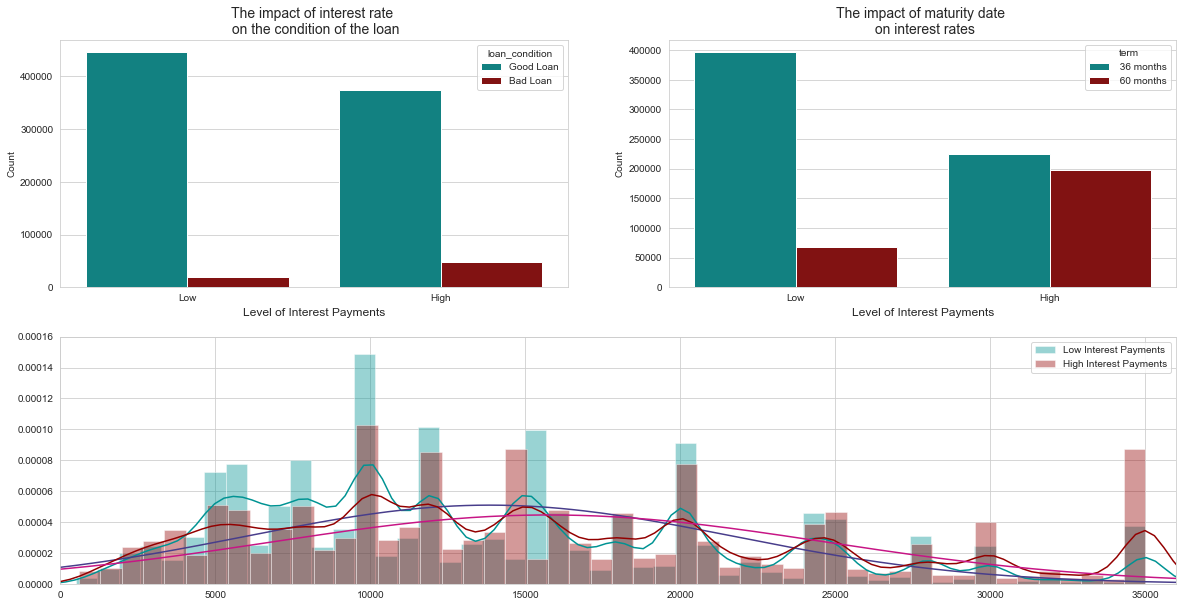

In [65]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_payments', data=loan_df, 
                  palette=palette, hue='loan_condition')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
ax1 = sns.countplot(x='interest_payments', data=loan_df, 
                   palette=palette, hue='term')

ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')
plt.subplot(212)
low = loan_df['loan_amount'].loc[loan_df['interest_payments'] == 'Low'].values
high = loan_df['loan_amount'].loc[loan_df['interest_payments'] == 'High'].values


ax2= sns.distplot(low, color='#009393', label='Low Interest Payments', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
ax3 = sns.distplot(high, color='#930000', label='High Interest Payments', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
plt.axis([0, 36000, 0, 0.00016])
plt.legend()


plt.show()

# Over-sampling using SMOTE

We will be using SMOTE technique in order to generate approximately same ratio of bad loans compared to good loans in both training and testing data. Remember that over 92% of the loans are considered good loans so it is important to have this same ration across training and testing sets.

In [66]:
data=loan_df

In [67]:
data['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [68]:
features=['loan_amount','funded_amount','investor_funds', 'interest_rate', 'dti','emp_length', 'loan_status',
          'grade','home_ownership','purpose','region','income_category']
data=pd.DataFrame(data, columns=features)
loan=['Current' ,'Issued', 'Charged Off','Late (31-120 days)','Late (16-30 days)','In Grace Period']
loan_risk=[ 'Charged Off','Late (31-120 days)','Late (16-30 days)','In Grace Period']
data = data[features]
data=data[data['loan_status'].isin(loan)]
mask = (data.loan_status.isin(loan_risk))
data['target'] = 0
data.loc[mask,'target'] = 1
data.head()

,loan_amount,funded_amount,investor_funds,interest_rate,dti,emp_length,loan_status,grade,home_ownership,purpose,region,income_category,target
1,2500.0,2500.0,2500.0,15.27,1.00,1,Charged Off,C,RENT,car,SouthEast,Low,1
4,3000.0,3000.0,3000.0,12.69,17.94,1,Current,B,RENT,other,West,Low,0
6,7000.0,7000.0,7000.0,15.96,23.51,8,Current,C,RENT,debt_consolidation,SouthEast,Low,0
8,5600.0,5600.0,5600.0,21.28,5.55,4,Charged Off,F,OWN,small_business,West,Low,1
9,5375.0,5375.0,5350.0,12.69,18.08,1,Charged Off,B,RENT,other,SouthWest,Low,1


In [69]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#X_scaled = preprocessing.scale(data)

train, test = train_test_split(data, test_size=0.3)
y_train = train['target']
y_test = test['target']
X_train = train[features]
X_test = test[features]

In [70]:
X_train.head()

,loan_amount,funded_amount,investor_funds,interest_rate,dti,emp_length,loan_status,grade,home_ownership,purpose,region,income_category
395217,20000.0,20000.0,20000.0,11.99,18.66,1,Current,B,MORTGAGE,credit_card,NorthEast,Medium
605258,35000.0,35000.0,34975.0,15.61,17.34,10,Current,D,MORTGAGE,debt_consolidation,SouthEast,Medium
735934,20000.0,20000.0,20000.0,10.99,23.46,7,Current,B,MORTGAGE,debt_consolidation,SouthEast,Low
648033,11200.0,11200.0,11200.0,16.55,38.56,2,Current,D,RENT,debt_consolidation,SouthWest,Low
612886,35000.0,35000.0,35000.0,13.33,15.64,1,Current,C,RENT,credit_card,West,Low


In [71]:
label_encoder = preprocessing.LabelEncoder()
# State is string and we want discre integer values
X_train['region'] = label_encoder.fit_transform(X_train['region'])
X_test['region'] = label_encoder.fit_transform(X_test['region'])
X_train['purpose'] = label_encoder.fit_transform(X_train['purpose'])
X_test['purpose'] = label_encoder.fit_transform(X_test['purpose'])
X_train['income_category'] = label_encoder.fit_transform(X_train['income_category'])
X_test['income_category'] = label_encoder.fit_transform(X_test['income_category'])

In [72]:
X_train = X_train._get_numeric_data()
X_test = X_test._get_numeric_data()

In [73]:
X_train.head()

,loan_amount,funded_amount,investor_funds,interest_rate,dti,emp_length,purpose,region,income_category
395217,20000.0,20000.0,20000.0,11.99,18.66,1,1,1,2
605258,35000.0,35000.0,34975.0,15.61,17.34,10,2,2,2
735934,20000.0,20000.0,20000.0,10.99,23.46,7,2,2,1
648033,11200.0,11200.0,11200.0,16.55,38.56,2,2,3,1
612886,35000.0,35000.0,35000.0,13.33,15.64,1,1,4,1


# Build Ensemble models

1. Run a set of models.3 in this case:Gradient Boosting,Logistic Regression and Random Forest
2. Makes prediction using the test set
3. Builds-up a table with evaluation metrics
4. Plots a roc curve of the estimators

We have use logistic regression as the meta-learner for the stacked model. Note that we can use k-folds cross validation to validate and tune the hyperparameters of the meta learner.

Additionally, we will plot ROC and PR curves using test data and evaluate the performance of the models.

In [106]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
rf_clf = RandomForestClassifier(n_estimators=300,n_jobs=2,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")
lg_clf= LogisticRegression()

In [107]:
lg_clf.fit(X_train,y_train)

C:\Users\Karan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [120]:
def calculate_roc_curve(y_test, y_score):    
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_score)
    #Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def calculate_confusion_matrix(y_test, y_pred):    
    cm=sklearn.metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(16, 8))
    plt.matshow(cm, cmap=plt.cm.Reds, alpha=0.2)
    for i in range(2):
      for j in range(2):
        plt.text(x=j, y=i, s=cm[i, j], ha="center", va="center")
    plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
    plt.xlabel("Predicted", fontdict={"fontsize": 14})
    plt.ylabel("Actual", fontdict={"fontsize": 14});

C:\Users\Karan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Intercept:  [-0.01867342]
Coefficient:  [[ 0.00026597  0.00186056 -0.00217196  0.01326641 -0.06032631 -0.07186975
  -0.02997256 -0.03207319 -0.02209795]]


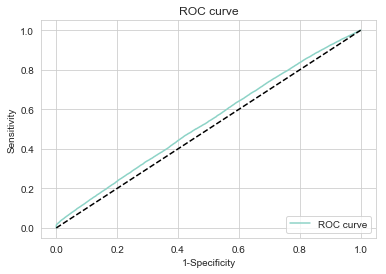

Accuracy:  0.9038365719980069


<Figure size 1152x576 with 0 Axes>

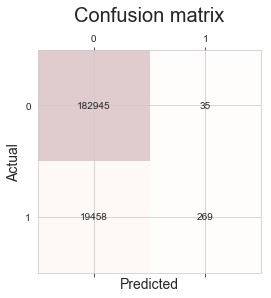

In [122]:
lg_clf=lg_clf.fit(X_train,y_train)
y_lg_pred=lg_clf.predict(X_test)
y_lg_score = lg_clf.predict_proba(X_test)[:,1]
print ("Intercept: ",lg_clf.intercept_)
print("Coefficient: ",lg_clf.coef_)
calculate_roc_curve(y_test, y_lg_score)

calculate_confusion_matrix(y_test, y_lg_pred)
print("Accuracy: ",sklearn.metrics.accuracy_score(y_test, y_lg_pred))

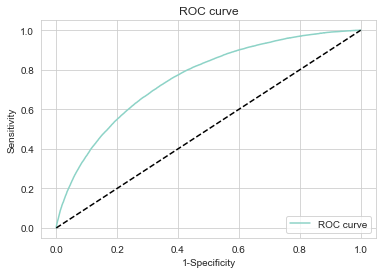

Accuracy:  0.8722047092601637


<Figure size 1152x576 with 0 Axes>

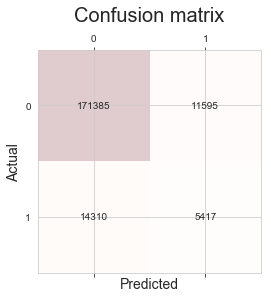

In [123]:
rf_clf=rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
y_score = rf_clf.predict_proba(X_test)[:,1]
#print ("Intercept is ",rf_clf.intercept_)
#print("Coefficient is ",rf_clf.coef_)
calculate_roc_curve(y_test, y_score)

calculate_confusion_matrix(y_test, y_pred)
print("Accuracy: ",sklearn.metrics.accuracy_score(y_test, y_pred))

Synthetic Minority Oversampling Technique (SMOTE): It over-samples the minority class but using synthesized examples. It operates on feature space not the data space. Here how it works:

1. Compute the k-nearest neighbors for all minority samples.
2. Randomly choose number between 1-k.
3. For each feature: 
    a. Compute the difference between minority sample and its randomly chosen neighbor (from previous step).
    b. Multiply the difference by random number between 0 and 1.
    c. Add the obtained feature to the synthesized sample attributes.

Repeat the above until we get the number of synthesized samples needed. More information can be found here.

In [127]:
!pip install imblearn

In [128]:
from imblearn.over_sampling import SMOTE
columns = X_train.columns
X,Y = SMOTE().fit_resample(X_train, y_train)
X=pd.DataFrame(data=X,columns=columns )
Y= pd.DataFrame(data=Y,columns=['Target'])

In [129]:
X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [130]:
X_os_train['region'] = label_encoder.fit_transform(X_os_train['region'])
X_os_test['region'] = label_encoder.fit_transform(X_os_test['region'])
X_os_train['purpose'] = label_encoder.fit_transform(X_os_train['purpose'])
X_os_test['purpose'] = label_encoder.fit_transform(X_os_test['purpose'])
X_os_train['income_category'] = label_encoder.fit_transform(X_os_train['income_category'])
X_os_test['income_category'] = label_encoder.fit_transform(X_os_test['income_category'])

In [131]:
X_os_test.head()

,loan_amount,funded_amount,investor_funds,interest_rate,dti,emp_length,purpose,region,income_category
426227,24000.0,24000.0,23975.0,10.99,22.15,10.0,1007,77151,18478
465977,10000.0,10000.0,10000.0,13.05,34.49,9.0,28160,77151,1673
368795,20000.0,20000.0,20000.0,13.99,10.93,10.0,1007,16530,18478
32730,18000.0,18000.0,18000.0,10.99,10.04,10.0,28160,41265,18478
364105,20000.0,20000.0,20000.0,9.99,22.69,2.0,28160,41265,1673


C:\Users\Karan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Karan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Intercept:  [-0.06275837]
Coefficient:  [[ 3.08291488e-04  2.48892353e-03 -2.82440519e-03  1.26716258e-01
  -3.60397579e-02 -4.30108582e-02 -2.34395431e-06 -1.47689312e-06
  -1.23470591e-05]]


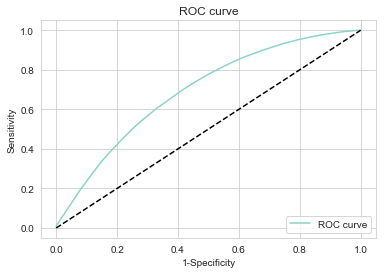

Accuracy:  0.6341064769305185


<Figure size 1152x576 with 0 Axes>

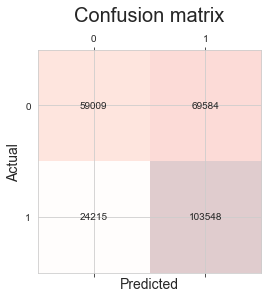

In [132]:
lg_clf=lg_clf.fit(X_os_train,y_os_train)
y_lg_pred=lg_clf.predict(X_os_test)
y_lg_score = lg_clf.predict_proba(X_os_test)[:,1]
print ("Intercept: ",lg_clf.intercept_)
print("Coefficient: ",lg_clf.coef_)
calculate_roc_curve(y_os_test, y_lg_score)

calculate_confusion_matrix(y_os_test, y_lg_pred)
print("Accuracy: ",sklearn.metrics.accuracy_score(y_os_test, y_lg_pred))

C:\Users\Karan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



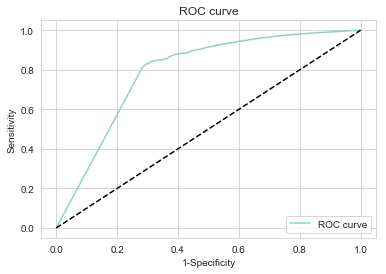

Accuracy:  0.5121744761191468


<Figure size 1152x576 with 0 Axes>

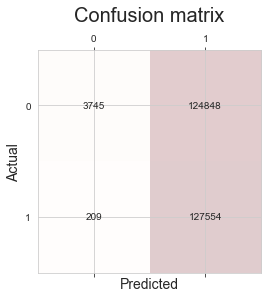

In [133]:
rf_clf=rf_clf.fit(X_os_train,y_os_train)
y_pred = rf_clf.predict(X_os_test)
y_score = rf_clf.predict_proba(X_os_test)[:,1]
#print ("Intercept is ",rf_clf.intercept_)
#print("Coefficient is ",rf_clf.coef_)
calculate_roc_curve(y_os_test, y_score)

calculate_confusion_matrix(y_os_test, y_pred)
print("Accuracy: ",sklearn.metrics.accuracy_score(y_os_test, y_pred))

# Conclusion

Having performd data cleaning and feature selection, we addressed the issue of data imbalance in most of the datasets using SMOTE, performed in depth exploratory data analysis leveraging various histograms, scatterplots and boxplots provided by the seaborn library to better support the analysis for our question which was nothing but 'Classification of good and bad loans'. We further went on to build a predictivve model using various predictive techniques constituted in the sklearn package. Use of Logistic Regression and Random Forests have been made where Random Forest outperformed Logistic regression.

The predictive models were aimed at prediciting the condition of the current loans that is whether the loan currently going on will default or no in the near fuure. It also provide competitive advantage to Lending CLub to mitigate the risk of loan defaults beforehand and without incurring major losses.